In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
%matplotlib inline
import importlib

from tqdm import tqdm, tnrange

In [2]:
df = pd.read_hdf('dataset/binance_data_train.h5', 'STW')
sample_len   = 480
obs_data_len = 192
step_len     = 1
n_action_intervals = 5
device = "cuda:3"

In [3]:
import DQNTradingAgent.dqn_agent as dqn_agent
from custom_hyperparameters import hyperparams
from envs.trading_env_integrated import TradingEnv

## draw fee_rate list

In [4]:
begin_point = np.random.randint(np.random.randint(len(df) - sample_len + 1))

In [5]:
env_name = ["bollinger", "macd", "stochastic", "rsi","0.000","0.003",'0.005']

In [39]:
def fee_rate_list(env_name, agent_num =1):
    load_location = 'saves/transfer/{}/{}'.format(env_name,agent_num)
    class args():
        def __init__(self, name,fee=0.001):
            self.environment=name
            self.fee = fee
            
    if env_name in ["0.000","0.003","0.005"]:
        args = args(env_name , float(env_name))
    else:
        args = args(env_name)
    
    env = TradingEnv(custom_args=args, env_id='custom_trading_env', obs_data_len=obs_data_len, step_len=step_len, sample_len=sample_len,
                               df=df, fee=args.fee, initial_budget=1, n_action_intervals=n_action_intervals, deal_col_name='c', sell_at_end=True,
                               feature_names=['o', 'h','l','c','v',
                                              'num_trades', 'taker_base_vol'])
    agent = dqn_agent.Agent(action_size=2 * n_action_intervals + 1, obs_len=obs_data_len, num_features=env.reset().shape[-1], **hyperparams)
    agent.qnetwork_local.load_state_dict(torch.load(os.path.join(load_location, 'TradingGym_Rainbow_400.pth'), map_location=device))
    agent.qnetwork_local.to(device)
    agent.qnetwork_local.eval()
    
    state = env.reset(fixed_begin_point = begin_point)
    fee_rate_list = []
    while True:
        action = int(agent.act(state, eps=0.))
        next_state, reward, done, info = env.step(action)
        state = next_state
        fee_rate_list.append(info['fee_rate'])
        if done:
            break
        
    return fee_rate_list

In [40]:
fee_rate_list_table={}
for i in tnrange(len(env_name), desc= "env"):
    env = env_name[i]
#     for agent_num in tnrange(1,31, desc=f"agent num"):       
    fee_rate_list_= fee_rate_list(env)

    
    fee_rate_list_table[env] = fee_rate_list_

[2019-09-10 12:36:54,282] Making new env: custom_trading_env
/home/jeffrey/Binanace_trading_simulation/agent/DQN/envs/trading_env_integrated.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.price = self.df_sample[self.price_name].as_matrix()
/home/jeffrey/Binanace_trading_simulation/agent/DQN/envs/trading_env_integrated.py:113: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.obs_features = self.df_sample[self.using_feature].as_matrix()
[2019-09-10 12:36:55,437] Making new env: custom_trading_env
[2019-09-10 12:36:56,384] Making new env: custom_trading_env
[2019-09-10 12:36:57,449] Making new env: custom_trading_env
[2019-09-10 12:36:59,156] Making new env: custom_trading_env
[2019-09-10 12:36:59,722] Making new env: custom_trading_env
[2019-09-10 12:37:00,285] Making new env: custom_trading_env


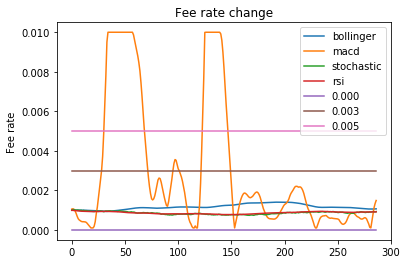

In [41]:
# compare plot
%matplotlib inline
for env in env_name:
#     if env=="macd":
#         continue
    plt.plot( fee_rate_list_table[env], label = env)
plt.title("Fee rate change")
plt.ylabel("Fee rate")
plt.legend()
plt.show()


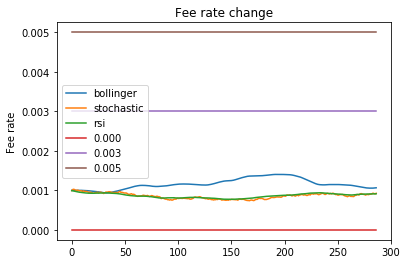

In [42]:
# compare plot
%matplotlib inline
for env in env_name:
    if env=="macd":
        continue
    plt.plot( fee_rate_list_table[env], label = env)
plt.title("Fee rate change")
plt.ylabel("Fee rate")
plt.legend()
plt.show()


## broken y chart

/home/jeffrey/anaconda3/envs/RL/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


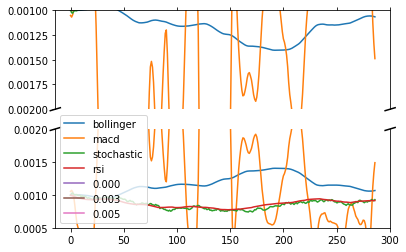

In [43]:
f, (ax, ax2) = plt.subplots(2, 1, sharex=True)

# plot the same data on both axes
for env in env_name:
    ax.plot(fee_rate_list_table[env], label = env)
    ax2.plot(fee_rate_list_table[env], label = env)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(.002, .001)  # outliers only
ax2.set_ylim(.0005, .002)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.legend()
plt.show()

In [44]:
import pickle

In [45]:
with open("saves/fee_rate_dict.pkl",'wb') as f:
    pickle.dump(fee_rate_list_table,f)

## draw total fee and volume 

In [12]:
def load_agent_and_run(env_name, agent_num, fee=0.001):

    load_location = 'saves/transfer/{}/{}'.format(env_name,agent_num)
    class args():
        def __init__(self, name,fee=0.001):
            self.environment=name
            self.fee = fee
    args = args(env_name, fee)
    env = TradingEnv(custom_args=args, env_id='custom_trading_env', obs_data_len=obs_data_len, step_len=step_len, sample_len=sample_len,
                               df=df, fee=args.fee, initial_budget=1, n_action_intervals=n_action_intervals, deal_col_name='c', sell_at_end=True,
                               feature_names=['o', 'h','l','c','v',
                                              'num_trades', 'taker_base_vol'])
    agent = dqn_agent.Agent(action_size=2 * n_action_intervals + 1, obs_len=obs_data_len, num_features=env.reset().shape[-1], **hyperparams)
    agent.qnetwork_local.load_state_dict(torch.load(os.path.join(load_location, 'TradingGym_Rainbow_400.pth'), map_location=device))
    agent.qnetwork_local.to(device)
    agent.qnetwork_local.eval()
    
    state = env.reset(fixed_begin_point = begin_point)
    while True:
        action = int(agent.act(state, eps=0.))
        next_state, reward, done, _ = env.step(action)
        state = next_state
        if done:
            break
        
    return env.total_fee, env.total_volume





In [13]:
fee_table = {}
volume_table = {}

In [14]:
fee_table.keys()

dict_keys([])

In [15]:
for i in tnrange(len(env_name), desc= "env"):
    env = env_name[i]
    
    env_fee = 0.
    env_volume = 0.
    for agent_num in tnrange(1,31, desc=f"agent num"):
        if env in ["0.000","0.003","0.005"]:
            fee, volume= load_agent_and_run(env,agent_num, float(env))
        else:
            fee, volume= load_agent_and_run(env,agent_num)
        env_fee+=fee
        env_volume+=volume
    
    fee_table[env] = env_fee
    volume_table[env] = env_volume

[2019-09-10 11:54:29,664] Making new env: custom_trading_env
[2019-09-10 11:54:30,811] Making new env: custom_trading_env
[2019-09-10 11:54:31,965] Making new env: custom_trading_env
[2019-09-10 11:54:33,131] Making new env: custom_trading_env
[2019-09-10 11:54:34,289] Making new env: custom_trading_env
[2019-09-10 11:54:35,449] Making new env: custom_trading_env
[2019-09-10 11:54:36,605] Making new env: custom_trading_env
[2019-09-10 11:54:37,756] Making new env: custom_trading_env
[2019-09-10 11:54:38,907] Making new env: custom_trading_env
[2019-09-10 11:54:40,056] Making new env: custom_trading_env
[2019-09-10 11:54:41,197] Making new env: custom_trading_env
[2019-09-10 11:54:42,357] Making new env: custom_trading_env
[2019-09-10 11:54:43,509] Making new env: custom_trading_env
[2019-09-10 11:54:44,668] Making new env: custom_trading_env
[2019-09-10 11:54:45,821] Making new env: custom_trading_env
[2019-09-10 11:54:46,977] Making new env: custom_trading_env
[2019-09-10 11:54:48,116

[2019-09-10 11:55:04,206] Making new env: custom_trading_env
[2019-09-10 11:55:05,153] Making new env: custom_trading_env
[2019-09-10 11:55:06,099] Making new env: custom_trading_env
[2019-09-10 11:55:07,049] Making new env: custom_trading_env
[2019-09-10 11:55:07,997] Making new env: custom_trading_env
[2019-09-10 11:55:08,943] Making new env: custom_trading_env
[2019-09-10 11:55:09,893] Making new env: custom_trading_env
[2019-09-10 11:55:10,842] Making new env: custom_trading_env
[2019-09-10 11:55:11,795] Making new env: custom_trading_env
[2019-09-10 11:55:12,755] Making new env: custom_trading_env
[2019-09-10 11:55:13,701] Making new env: custom_trading_env
[2019-09-10 11:55:14,651] Making new env: custom_trading_env
[2019-09-10 11:55:15,603] Making new env: custom_trading_env
[2019-09-10 11:55:16,558] Making new env: custom_trading_env
[2019-09-10 11:55:17,508] Making new env: custom_trading_env
[2019-09-10 11:55:18,458] Making new env: custom_trading_env
[2019-09-10 11:55:19,408

[2019-09-10 11:55:32,709] Making new env: custom_trading_env
[2019-09-10 11:55:33,781] Making new env: custom_trading_env
[2019-09-10 11:55:34,851] Making new env: custom_trading_env
[2019-09-10 11:55:35,931] Making new env: custom_trading_env
[2019-09-10 11:55:37,010] Making new env: custom_trading_env
[2019-09-10 11:55:38,094] Making new env: custom_trading_env
[2019-09-10 11:55:39,169] Making new env: custom_trading_env
[2019-09-10 11:55:40,242] Making new env: custom_trading_env
[2019-09-10 11:55:41,315] Making new env: custom_trading_env
[2019-09-10 11:55:42,438] Making new env: custom_trading_env
[2019-09-10 11:55:43,514] Making new env: custom_trading_env
[2019-09-10 11:55:44,589] Making new env: custom_trading_env
[2019-09-10 11:55:45,660] Making new env: custom_trading_env
[2019-09-10 11:55:46,730] Making new env: custom_trading_env
[2019-09-10 11:55:47,801] Making new env: custom_trading_env
[2019-09-10 11:55:48,866] Making new env: custom_trading_env
[2019-09-10 11:55:49,932

[2019-09-10 11:56:04,959] Making new env: custom_trading_env
[2019-09-10 11:56:06,686] Making new env: custom_trading_env
[2019-09-10 11:56:08,413] Making new env: custom_trading_env
[2019-09-10 11:56:10,142] Making new env: custom_trading_env
[2019-09-10 11:56:11,865] Making new env: custom_trading_env
[2019-09-10 11:56:13,605] Making new env: custom_trading_env
[2019-09-10 11:56:15,338] Making new env: custom_trading_env
[2019-09-10 11:56:17,067] Making new env: custom_trading_env
[2019-09-10 11:56:18,802] Making new env: custom_trading_env
[2019-09-10 11:56:20,544] Making new env: custom_trading_env
[2019-09-10 11:56:22,274] Making new env: custom_trading_env
[2019-09-10 11:56:24,000] Making new env: custom_trading_env
[2019-09-10 11:56:25,733] Making new env: custom_trading_env
[2019-09-10 11:56:27,468] Making new env: custom_trading_env
[2019-09-10 11:56:29,197] Making new env: custom_trading_env
[2019-09-10 11:56:30,923] Making new env: custom_trading_env
[2019-09-10 11:56:32,707

[2019-09-10 11:56:56,971] Making new env: custom_trading_env
[2019-09-10 11:56:57,538] Making new env: custom_trading_env
[2019-09-10 11:56:58,108] Making new env: custom_trading_env
[2019-09-10 11:56:58,677] Making new env: custom_trading_env
[2019-09-10 11:56:59,246] Making new env: custom_trading_env
[2019-09-10 11:56:59,813] Making new env: custom_trading_env
[2019-09-10 11:57:00,372] Making new env: custom_trading_env
[2019-09-10 11:57:00,934] Making new env: custom_trading_env
[2019-09-10 11:57:01,500] Making new env: custom_trading_env
[2019-09-10 11:57:02,065] Making new env: custom_trading_env
[2019-09-10 11:57:02,632] Making new env: custom_trading_env
[2019-09-10 11:57:03,204] Making new env: custom_trading_env
[2019-09-10 11:57:03,776] Making new env: custom_trading_env
[2019-09-10 11:57:04,346] Making new env: custom_trading_env
[2019-09-10 11:57:04,915] Making new env: custom_trading_env
[2019-09-10 11:57:05,480] Making new env: custom_trading_env
[2019-09-10 11:57:06,049

[2019-09-10 11:57:14,068] Making new env: custom_trading_env
[2019-09-10 11:57:14,639] Making new env: custom_trading_env
[2019-09-10 11:57:15,208] Making new env: custom_trading_env
[2019-09-10 11:57:15,779] Making new env: custom_trading_env
[2019-09-10 11:57:16,348] Making new env: custom_trading_env
[2019-09-10 11:57:16,919] Making new env: custom_trading_env
[2019-09-10 11:57:17,487] Making new env: custom_trading_env
[2019-09-10 11:57:18,060] Making new env: custom_trading_env
[2019-09-10 11:57:18,631] Making new env: custom_trading_env
[2019-09-10 11:57:19,205] Making new env: custom_trading_env
[2019-09-10 11:57:19,776] Making new env: custom_trading_env
[2019-09-10 11:57:20,353] Making new env: custom_trading_env
[2019-09-10 11:57:20,924] Making new env: custom_trading_env
[2019-09-10 11:57:21,501] Making new env: custom_trading_env
[2019-09-10 11:57:22,073] Making new env: custom_trading_env
[2019-09-10 11:57:22,648] Making new env: custom_trading_env
[2019-09-10 11:57:23,223

[2019-09-10 11:57:31,245] Making new env: custom_trading_env
[2019-09-10 11:57:31,816] Making new env: custom_trading_env
[2019-09-10 11:57:32,389] Making new env: custom_trading_env
[2019-09-10 11:57:32,961] Making new env: custom_trading_env
[2019-09-10 11:57:33,538] Making new env: custom_trading_env
[2019-09-10 11:57:34,109] Making new env: custom_trading_env
[2019-09-10 11:57:34,682] Making new env: custom_trading_env
[2019-09-10 11:57:35,255] Making new env: custom_trading_env
[2019-09-10 11:57:35,829] Making new env: custom_trading_env
[2019-09-10 11:57:36,399] Making new env: custom_trading_env
[2019-09-10 11:57:36,967] Making new env: custom_trading_env
[2019-09-10 11:57:37,535] Making new env: custom_trading_env
[2019-09-10 11:57:38,105] Making new env: custom_trading_env
[2019-09-10 11:57:38,677] Making new env: custom_trading_env
[2019-09-10 11:57:39,251] Making new env: custom_trading_env
[2019-09-10 11:57:39,825] Making new env: custom_trading_env
[2019-09-10 11:57:40,401

In [16]:
env_fee

0.06916114935023294

In [17]:
env_volume

13222.812484104685

#load fee_table and volume_table
import pickle
with open('fee_table.pkl','rb') as f:
    fee_table_ = pickle.load(f)
with open('volume_table.pkl','rb') as f:
    volume_table_ = pickle.load(f)

fee_table = {**fee_table, **fee_table_}
fee_table

volume_table = {**volume_table, **volume_table_}
volume_table

In [18]:
%matplotlib inline

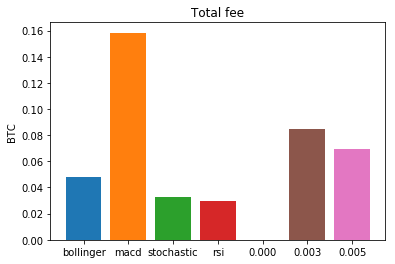

In [19]:
# compare plot
# env_name = ["bollinger", "macd", "stochastic", "rsi","0.003",'0.005']
for env in env_name:
    plt.bar(x = env, height = fee_table[env])
plt.title("Total fee")
plt.ylabel("BTC")
plt.show()


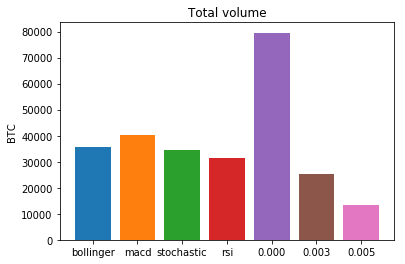

In [20]:
# compare plot
for env in env_name:
    plt.bar(x = env, height = volume_table[env])
plt.title("Total volume")
plt.ylabel("BTC")
plt.show()


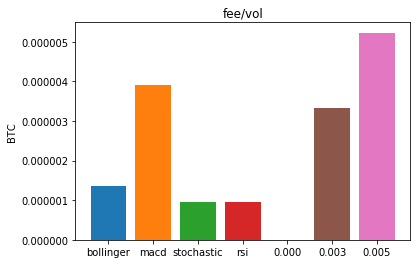

In [21]:
avg_fee_table=dict(zip(fee_table.keys(),np.array(list(fee_table.values()))/np.array(list(volume_table.values()))))
for env in env_name:
    plt.bar(x = env, height = avg_fee_table[env])
plt.title("fee/vol")
plt.ylabel("BTC")
plt.show()

In [22]:
# save
import pickle

with open("saves/fee_table.pkl",'wb') as f:
    pickle.dump(fee_table, f)

with open("saves/volume_table.pkl",'wb') as f:
    pickle.dump(volume_table, f)